<a href="https://colab.research.google.com/github/ZohebAbai/Tiny-ImageNet-Challenge/blob/master/TinyImageNet_Network_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing libraries and Downloading Dataset

In [1]:
## Download the dataset and unzip it 
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-12-13 02:25:11--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  5.49MB/s    in 34s     

2021-12-13 02:25:46 (6.90 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
#Unzip data
!unzip 'tiny-imagenet-200.zip'
!ls

In [1]:
!pip install keras==2.3.1
!pip install git+https://github.com/keras-team/keras-contrib.git

     |████████████████████████████████| 377 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 603 kB 72.3 MB/s eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
You should consider upgrading via the '/home/ecbm4040/envTF24/bin/python3 -m pip install --upgrade pip' command.
  Cloning https://github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-41ut1s85
  Running command git clone -q https://github.com/keras-team/keras-contrib.git /tmp/pip-req-build-41ut1s85
  Resolved https://github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
You should consider upgrading via the '/home/ecbm4040/envTF24/bin/python3 -m pip install --upgrade pip' command.


In [1]:
# Importing important libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, concatenate, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import imgaug as ia
from imgaug import augmenters as iaa
from keras_contrib.callbacks import CyclicLR

import tensorflow_addons as tfa

# random seed
np.random.seed(seed=101)
ia.seed(101)

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

# Don't pre-allocate memory; allocate as-needed
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

# Create a session with the above options specified.
#k.tensorflow_backend.set_session(tf.Session(config=config))

# input image dimensions
img_height = 64
img_width = 64
channels = 3

# Hyperparameters
batch_size = 128
num_classes = 200
epochs = 24
num_train = 100000
num_validation = 10000

Using TensorFlow backend.


In [2]:
#Load validation data
import numpy as np
import pandas as pd
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


# Image Augmentation

In [3]:
# Defining Customized Imagedatagenerator using imgaug library
def CustomImageDataGen(input_img):
  # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
  # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
  # image.
  sometimes = lambda aug: iaa.Sometimes(0.5, aug)
  
  seq = iaa.Sequential([
      iaa.Fliplr(0.5), # horizontal flips
      iaa.Flipud(0.2), # vertical flips
      
      # Small gaussian blur with random sigma between 0 and 0.5.
      # But we only blur about 50% of all images.
      sometimes(iaa.GaussianBlur(sigma=(0, 2.0))),
      
      # crop images by -10% to 20% of their height/width
      sometimes(iaa.CropAndPad(
          percent=(-0.1, 0.2),
          pad_mode=ia.ALL,
          pad_cval=(0, 255)
        )),
      
      # Apply affine transformations to some of the images
      # - scale to 80-120% of image height/width (each axis independently)
      # - translate by -20 to +20 relative to height/width (per axis)
      # - rotate by -45 to +45 degrees
      # - shear by -16 to +16 degrees
      # - order: use nearest neighbour or bilinear interpolation (fast)
      # - mode: use any available mode to fill newly created pixels
      #         see API or scikit-image for which modes are available
      # - cval: if the mode is constant, then use a random brightness
      #         for the newly created pixels (e.g. sometimes black,
      #         sometimes white)
      sometimes(iaa.Affine(
          scale={"x": (0.8, 1.5), "y": (0.8, 1.5)},
          translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
          rotate=(-45, 45),
          shear=(-16, 16),
          order=[0, 1],
          cval=(0, 255),
          mode=ia.ALL
      )),
      
      #drop 2-5% percent of the original size, leading to large dropped
      # rectangles.
      sometimes(iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    )),
                
      # Make some images brighter and some darker.
      # In 20% of all cases, we sample the multiplier once per channel,
      # which can end up changing the color of the images.
      sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.2)),
      
      #Improve or worsen the contrast of images.
      #Comment it out after third model run (extreme saturation)
      sometimes(iaa.ContrastNormalization((0.75, 1.5), per_channel=0.5)), 
     ],
     # do all of the above augmentations in random order
     random_order = True) # apply augmenters in random order
  
  output_img = seq.augment_image(input_img)
  return output_img

train_datagen = ImageDataGenerator(rescale=1/255., preprocessing_function = CustomImageDataGen)
valid_datagen = ImageDataGenerator(rescale=1/255.)

In [4]:
#Generate training data
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', 
                                                    target_size=(img_width, img_height), 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical', 
                                                    shuffle=True, seed=101)

Found 100000 images belonging to 200 classes.


In [5]:
#Generate validation data
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', 
                                                         x_col='File', y_col='Class', 
                                                         target_size=(img_width, img_height),
                                                         class_mode='categorical', 
                                                         batch_size=batch_size, 
                                                         shuffle=False, seed=101)

Found 10000 validated image filenames belonging to 200 classes.


# Model Building and Compilation

### Below is the custom Resnet Model, where architecture is inspired from Wide-Resnet and Resnet-18 keras models. As required for the project followings have not been used :
1. 1x1 for an increasing number of channels
2. dropout
3. fully connected layers
4. test dataset for training
5. pre-trained model/weights
6. someone else's code 

### Note : For running the new model after 8 hours, don't run beyond this, as the saved model contains model architecture, weights and optimizer.

In [7]:
# Model building
input = Input(shape=(img_height, img_width, channels))

# Block 1
layer0 = Conv2D(32, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(input)
layer0 = BatchNormalization()(layer0)
layer0 = Activation('relu')(layer0)

skip_connection_1 = layer0

# Block 2

layer1 = Conv2D(128, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer0)
layer1 = BatchNormalization()(layer1)
layer1 = Activation('relu')(layer1)

layer2 = Conv2D(128, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = Activation('relu')(layer2)

layer3 = Conv2D(128, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = Activation('relu')(layer3)

layer4 = Conv2D(128, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer3)
layer4 = BatchNormalization()(layer4)
layer4 = Activation('relu')(layer4)

layer5 = concatenate([skip_connection_1, layer4])
layer5 = BatchNormalization()(layer5)
layer5 = Activation('relu')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2))(layer5)

skip_connection_2 = layer5

# Block 3

layer6 = Conv2D(256, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer5)
layer6 = BatchNormalization()(layer6)
layer6 = Activation('relu')(layer6)

layer7 = Conv2D(256, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer6)
layer7 = BatchNormalization()(layer7)
layer7 = Activation('relu')(layer7)

layer8 = Conv2D(256, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer7)
layer8 = BatchNormalization()(layer8)
layer8 = Activation('relu')(layer8)

layer9 = Conv2D(256, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer8)
layer9 = BatchNormalization()(layer9)
layer9 = Activation('relu')(layer9)

layer10 = concatenate([skip_connection_2, layer9])
layer10 = BatchNormalization()(layer10)
layer10 = Activation('relu')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2))(layer10)

skip_connection_3 = layer10


# Block 4

layer11 = Conv2D(512, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer10)
layer11 = BatchNormalization()(layer11)
layer11 = Activation('relu')(layer11)

layer12 = Conv2D(512, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer11)
layer12 = BatchNormalization()(layer12)
layer12 = Activation('relu')(layer12)

layer13 = Conv2D(512, (3,3), padding='same',kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer12)
layer13 = BatchNormalization()(layer13)
layer13 = Activation('relu')(layer13)

layer14 = Conv2D(512, (3,3), padding='same',kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer13)
layer14 = BatchNormalization()(layer14)
layer14 = Activation('relu')(layer14)

layer15 = concatenate([skip_connection_3, layer14])
layer15 = BatchNormalization()(layer15)
layer15 = Activation('relu')(layer15)
layer15 = MaxPooling2D(pool_size=(2, 2))(layer15)


#Layer 16
layer16 = Conv2D(num_classes, (1,1), padding='same',kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer15)
layer16 = GlobalAveragePooling2D()(layer16)

#Output Layer
output = Activation('softmax')(layer16)

In [8]:
# Model Summary
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### First training round with base_lr=1e-4 and max_lr=6r-4 

In [9]:
# Callbacks

clr = CyclicLR(base_lr=0.0001, max_lr=0.0006, step_size=4686., mode='triangular2') 

checkpointer = ModelCheckpoint(filepath="./Network2_model/model1.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")

# Compile the Model
model.compile(loss='categorical_crossentropy',
              optimizer= RMSprop(lr= 0.0001, epsilon=1e-08),
              #optimizer= Adam(lr= 0.0001, epsilon=1e-08),
              #optimizer = SGD(momentum=0.9),
              metrics=['accuracy'])

# Fit the model in the first round with base_lr=1e-4 and max_lr=6r-4
history1 = model.fit_generator(train_generator,
                    epochs=24,
                    steps_per_epoch= num_train // batch_size,
                    validation_steps= num_validation // batch_size,
                    validation_data=validation_generator,
                    verbose=1, callbacks=[clr ,checkpointer]
                   )

/home/ecbm4040/envTF24/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ecbm4040/envTF24/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/24
781/781 [==============================] - 634s 794ms/step - loss: 5.7628 - accuracy: 0.0340 - val_loss: 5.2207 - val_accuracy: 0.0784

Epoch 00001: val_accuracy improved from -inf to 0.07843, saving model to ./Network2_model/model1.hdf5
Epoch 2/24
781/781 [==============================] - 624s 798ms/step - loss: 4.9807 - accuracy: 0.0938 - val_loss: 4.8101 - val_accuracy: 0.1114

Epoch 00002: val_accuracy improved from 0.07843 to 0.11138, saving model to ./Network2_model/model1.hdf5
Epoch 3/24
781/781 [==============================] - 620s 794ms/step - loss: 4.5904 - accuracy: 0.1350 - val_loss: 4.2802 - val_accuracy: 0.1725

Epoch 00003: val_accuracy improved from 0.11138 to 0.17248, saving model to ./Network2_model/model1.hdf5
Epoch 4/24
781/781 [==============================] - 621s 794ms/step - loss: 4.3482 - accuracy: 0.1649 - val_loss: 4.5731 - val_accuracy: 0.1520

Epoch 00004: val_accuracy did not improve from 0.17248
Epoch 5/24
781/781 [=========================

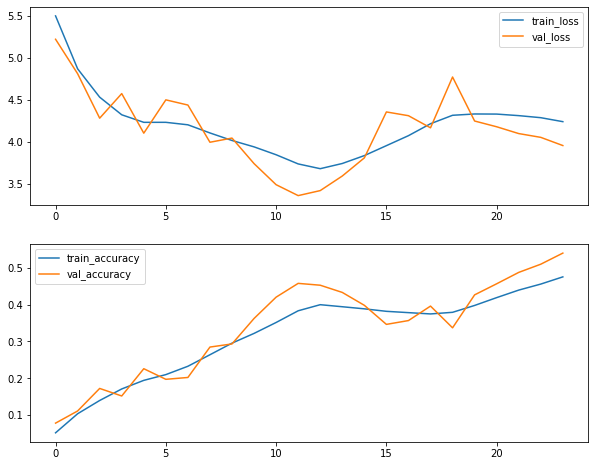

In [10]:
#Plot the loss and accuracy
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history1.history["loss"], label="train_loss")
ax[0].plot(history1.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history1.history["accuracy"], label= "train_accuracy")
ax[1].plot(history1.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

### In the first round, the max validation accuracy is 53.94%

In [11]:
#Save the training history
pd.DataFrame(history1.history).to_csv('./history/network2_model1.csv')

### Second round with base_lr=1e-05 and max_lr=6e-05

In [6]:
# load the model
from tensorflow.keras.models import load_model
new_model = load_model("./Network2_model/model1.hdf5")

In [7]:
# callbacks
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
steps_per_epoch= num_train // batch_size
clr = CyclicLR(base_lr=0.00001, max_lr=0.00006, step_size=4686., mode='triangular2') 

checkpointer_2= ModelCheckpoint(filepath="./Network2_model/model2.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")
# fit the model 
history2 = new_model.fit(train_generator,
                        epochs=24,
                        steps_per_epoch= num_train // batch_size,
                        validation_steps= num_validation // batch_size,
                        validation_data=validation_generator,
                        verbose=1, callbacks=[clr, checkpointer_2]
                       )

/home/ecbm4040/envTF24/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/24
781/781 [==============================] - 612s 768ms/step - loss: 4.1150 - accuracy: 0.5084 - val_loss: 3.7943 - val_accuracy: 0.5812

Epoch 00001: val_accuracy improved from -inf to 0.58123, saving model to ./Model/model2.hdf5
Epoch 2/24
781/781 [==============================] - 615s 787ms/step - loss: 4.0863 - accuracy: 0.5136 - val_loss: 3.8080 - val_accuracy: 0.5770

Epoch 00002: val_accuracy did not improve from 0.58123
Epoch 3/24
781/781 [==============================] - 615s 787ms/step - loss: 4.0837 - accuracy: 0.5158 - val_loss: 3.8099 - val_accuracy: 0.5781

Epoch 00003: val_accuracy did not improve from 0.58123
Epoch 4/24
781/781 [==============================] - 613s 784ms/step - loss: 4.1024 - accuracy: 0.5145 - val_loss: 3.8366 - val_accuracy: 0.5793

Epoch 00004: val_accuracy did not improve from 0.58123
Epoch 5/24
781/781 [==============================] - 615s 787ms/step - loss: 4.1027 - accuracy: 0.5198 - val_loss: 3.8503 - val_accuracy: 0.5733

Epoch 0

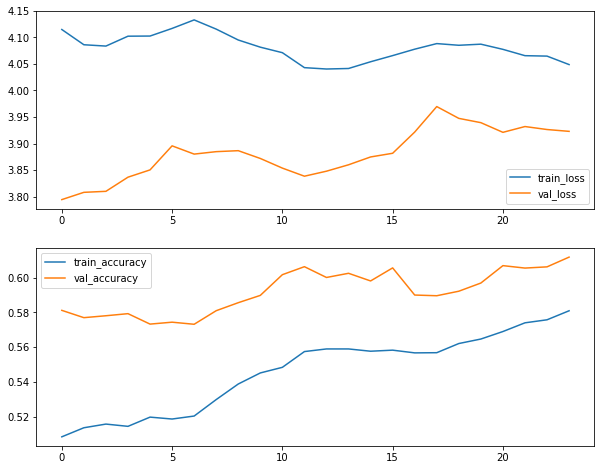

In [8]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history2.history["loss"], label="train_loss")
ax[0].plot(history2.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history2.history["accuracy"], label= "train_accuracy")
ax[1].plot(history2.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

### The max validation accuracy is 61.19%

In [9]:
#Save the result
pd.DataFrame(history2.history).to_csv('./history/network2_model2.csv')

### Before further running the third round, we shall analyse the accuracy of individual classes

In [6]:
# load the model after 16 hours
from tensorflow.keras.models import load_model
extended_model = load_model("./Network2_model/model2.hdf5")

In [12]:
#Prediction
pred=extended_model.predict(validation_generator, steps= np.ceil(num_validation/batch_size), verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

79/79 [==============================] - 19s 244ms/step


In [13]:
# Predicted class indices of 1st 10 val images
predicted_class_indices[:10]

array([107,  40,  89,  69,  69, 161, 147,  73, 145,  39])

In [14]:
# True class indices of 1st 10 val images
validation_generator.classes[:10]

[107, 139, 140, 69, 69, 161, 147, 73, 145, 39]

In [15]:
# Predicted classes from their indices
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions[:10]

['n03444034',
 'n02231487',
 'n03014705',
 'n02808440',
 'n02808440',
 'n04399382',
 'n04179913',
 'n02823428',
 'n04146614',
 'n02226429']

In [16]:
# Validation class names from words.txt
import os
class_to_name = dict()
file = open('tiny-imagenet-200/words.txt','r')
data= file.readlines()
for line in data:
  words = line.strip('\n').split('\t')
  class_to_name[words[0]] = words[1].split(',')[0]
file.close()

In [17]:
# Asserting Validation Class names from words.txt
validation_class_names={}
for _class in validation_generator.class_indices.keys():
  validation_class_names.update({_class : class_to_name[_class]})

In [18]:
# Classification Report of val classes
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(validation_generator.classes, predicted_class_indices,
                            #target_names=validation_generator.class_indices.keys(),
                            target_names=validation_class_names.values(),
                            digits=4))

                          precision    recall  f1-score   support

                goldfish     0.8491    0.9000    0.8738        50
European fire salamander     0.8627    0.8800    0.8713        50
                bullfrog     0.6042    0.5800    0.5918        50
             tailed frog     0.6176    0.4200    0.5000        50
      American alligator     0.6038    0.6400    0.6214        50
         boa constrictor     0.4600    0.4600    0.4600        50
               trilobite     0.7037    0.7600    0.7308        50
                scorpion     0.7674    0.6600    0.7097        50
             black widow     0.8125    0.7800    0.7959        50
               tarantula     0.6122    0.6000    0.6061        50
               centipede     0.5870    0.5400    0.5625        50
                   goose     0.8043    0.7400    0.7708        50
                   koala     0.7692    0.8000    0.7843        50
               jellyfish     0.7119    0.8400    0.7706        50
         

### We found significant difference in precision among groups.

### We keep training the model with base_lr=1e-5 and max_lr=6e-5, and step_size in no. of epochs = 4.

In [7]:
# Callbacks

clr = CyclicLR(base_lr=0.00001, max_lr=0.00006, step_size=3128., mode='triangular2')

checkpointer_3= ModelCheckpoint(filepath="./Network2_model/model3.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")
# fit the model
history3 = extended_model.fit(train_generator,
                             epochs=epochs,
                             steps_per_epoch= np.ceil(num_train/batch_size),
                             validation_steps= np.ceil(num_validation/batch_size),
                             validation_data=validation_generator,
                             verbose=1, callbacks=[clr,checkpointer_3],
                             )

/home/ecbm4040/envTF24/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/24
782/782 [==============================] - 632s 793ms/step - loss: 4.0474 - accuracy: 0.5827 - val_loss: 3.9763 - val_accuracy: 0.6005

Epoch 00001: val_accuracy improved from -inf to 0.60050, saving model to ./Network2_model/model3.hdf5
Epoch 2/24
782/782 [==============================] - 621s 794ms/step - loss: 4.0891 - accuracy: 0.5744 - val_loss: 4.0012 - val_accuracy: 0.5937

Epoch 00002: val_accuracy did not improve from 0.60050
Epoch 3/24
782/782 [==============================] - 621s 794ms/step - loss: 4.1253 - accuracy: 0.5690 - val_loss: 4.0689 - val_accuracy: 0.5839

Epoch 00003: val_accuracy did not improve from 0.60050
Epoch 4/24
782/782 [==============================] - 620s 792ms/step - loss: 4.1697 - accuracy: 0.5660 - val_loss: 4.1400 - val_accuracy: 0.5782

Epoch 00004: val_accuracy did not improve from 0.60050
Epoch 5/24
782/782 [==============================] - 620s 793ms/step - loss: 4.1991 - accuracy: 0.5642 - val_loss: 4.1326 - val_accuracy: 0.5852

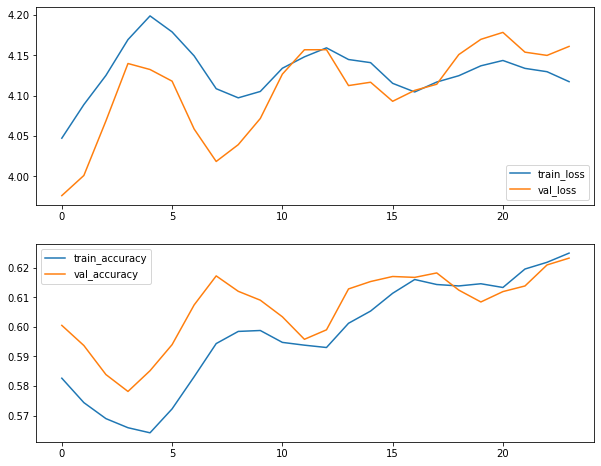

In [8]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history3.history["loss"], label="train_loss")
ax[0].plot(history3.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history3.history["accuracy"], label= "train_accuracy")
ax[1].plot(history3.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

### The training early stopped in the 11th epoch and  max validation accuracy is 58.20%.

In [9]:
#Save the results
pd.DataFrame(history3.history).to_csv('./history/network2_model3.csv')

### The fourth round with base_lr=1e-6 and max_lr=6e-6.
#### There is only 12 epochs

In [10]:
# load the model
#from keras.models import load_model
extended_model = load_model("./Network2_model/model3.hdf5")

In [11]:
# Callbacks

clr = CyclicLR(base_lr=0.000001, max_lr=0.000006, step_size=1564., mode='triangular2') 

checkpointer_4 = ModelCheckpoint(filepath="./Network2_model/model4.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")
# fit the model
history4=extended_model.fit_generator(train_generator,
                             epochs=12,
                             steps_per_epoch= np.ceil(num_train/batch_size),
                             validation_steps= np.ceil(num_validation/batch_size),
                             validation_data=validation_generator,
                             verbose=1, callbacks=[clr, checkpointer_4]
                             )

/home/ecbm4040/envTF24/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ecbm4040/envTF24/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/12
782/782 [==============================] - 625s 796ms/step - loss: 4.0914 - accuracy: 0.6330 - val_loss: 4.1291 - val_accuracy: 0.6262

Epoch 00001: val_accuracy improved from -inf to 0.62620, saving model to ./Network2_model/model4.hdf5
Epoch 2/12
782/782 [==============================] - 623s 797ms/step - loss: 4.0917 - accuracy: 0.6325 - val_loss: 4.1376 - val_accuracy: 0.6249

Epoch 00002: val_accuracy did not improve from 0.62620
Epoch 3/12
782/782 [==============================] - 623s 797ms/step - loss: 4.0941 - accuracy: 0.6336 - val_loss: 4.1341 - val_accuracy: 0.6256

Epoch 00003: val_accuracy did not improve from 0.62620
Epoch 4/12
782/782 [==============================] - 623s 796ms/step - loss: 4.0937 - accuracy: 0.6334 - val_loss: 4.1295 - val_accuracy: 0.6254

Epoch 00004: val_accuracy did not improve from 0.62620
Epoch 5/12
782/782 [==============================] - 623s 797ms/step - loss: 4.0839 - accuracy: 0.6367 - val_loss: 4.1337 - val_accuracy: 0.6266

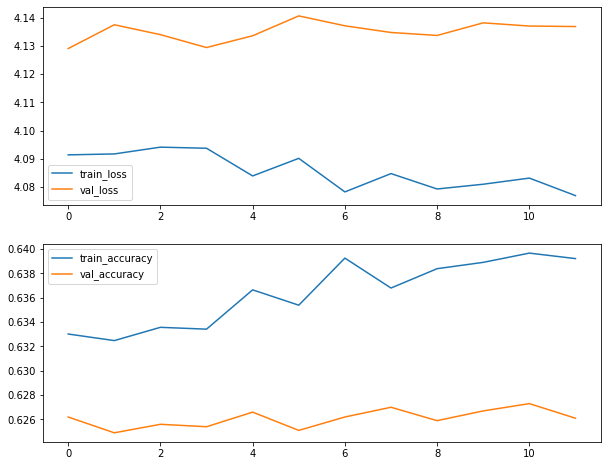

In [12]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history4.history["loss"], label="train_loss")
ax[0].plot(history4.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history4.history["accuracy"], label= "train_accuracy")
ax[1].plot(history4.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

### The max validation accuracy is 62.73%

In [13]:
pd.DataFrame(history4.history).to_csv('./history/network2_model4.csv')

### The fifth round with base_lr=1e-05 and max_lr=6e-5

In [20]:
# load the model after 28 hours
from tensorflow.keras.models import load_model
extended_model = load_model("./Network2_model/model4.hdf5")

In [14]:
# Callbacks
clr = CyclicLR(base_lr=0.00001, max_lr=0.00006, step_size=1564., mode='triangular2') #Cyclic learning rate
checkpointer_5 = ModelCheckpoint(filepath="./Network2_model/model5.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")
# fit the model
history5 = extended_model.fit_generator(train_generator,
                             epochs=12,
                             steps_per_epoch= np.ceil(num_train/batch_size),
                             validation_steps= np.ceil(num_validation/batch_size),
                             validation_data=validation_generator,
                             verbose=1, callbacks=[clr, checkpointer_5]
                             )

Epoch 1/12
782/782 [==============================] - 622s 795ms/step - loss: 4.1369 - accuracy: 0.6241 - val_loss: 4.2709 - val_accuracy: 0.6039

Epoch 00001: val_accuracy improved from -inf to 0.60390, saving model to ./Network2_model/model5.hdf5
Epoch 2/12
782/782 [==============================] - 623s 797ms/step - loss: 4.2435 - accuracy: 0.6023 - val_loss: 4.4280 - val_accuracy: 0.5826

Epoch 00002: val_accuracy did not improve from 0.60390
Epoch 3/12
782/782 [==============================] - 623s 797ms/step - loss: 4.2859 - accuracy: 0.5986 - val_loss: 4.3128 - val_accuracy: 0.6018

Epoch 00003: val_accuracy did not improve from 0.60390
Epoch 4/12
782/782 [==============================] - 623s 797ms/step - loss: 4.2230 - accuracy: 0.6176 - val_loss: 4.2253 - val_accuracy: 0.6228

Epoch 00004: val_accuracy improved from 0.60390 to 0.62280, saving model to ./Network2_model/model5.hdf5
Epoch 5/12
782/782 [==============================] - 623s 797ms/step - loss: 4.1849 - accuracy

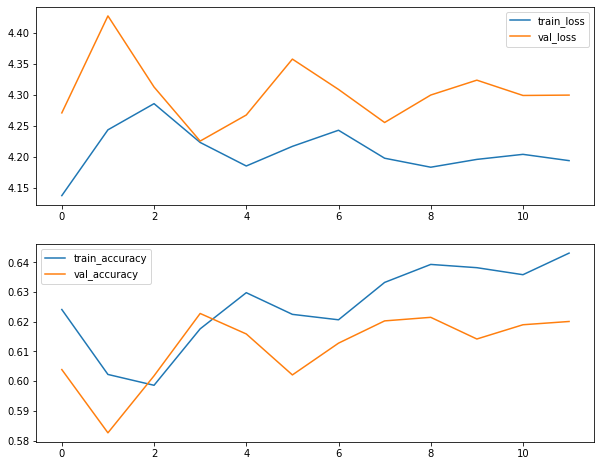

In [15]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history5.history["loss"], label="train_loss")
ax[0].plot(history5.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history5.history["accuracy"], label= "train_accuracy")
ax[1].plot(history5.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

### The max validation accuracy is 62.28%.

In [16]:
pd.DataFrame(history5.history).to_csv('./history/network2_model5.csv')

### The sixth round with base_lr=1e-07 and max_lr=6e-07

In [9]:
# load the model after 32 hours
from tensorflow.keras.models import load_model
extended_model = load_model("./Network2_model/model5.hdf5")

In [18]:
# Callbacks
clr = CyclicLR(base_lr=0.0000001, max_lr=0.0000006, step_size=1564., mode='triangular2') #Cyclic learning rate

checkpointer_6 = ModelCheckpoint(filepath="./Network2_model/model6.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")
# fit the model
history6 = extended_model.fit_generator(train_generator,
                             epochs=12,
                             steps_per_epoch= np.ceil(num_train/batch_size),
                             validation_steps= np.ceil(num_validation/batch_size),
                             validation_data=validation_generator,
                             verbose=1, callbacks=[clr, checkpointer_6]
                             )

Epoch 1/12
782/782 [==============================] - 623s 796ms/step - loss: 4.1633 - accuracy: 0.6498 - val_loss: 4.2754 - val_accuracy: 0.6270

Epoch 00001: val_accuracy improved from -inf to 0.62700, saving model to ./Network2_model/model6.hdf5
Epoch 2/12
782/782 [==============================] - 624s 797ms/step - loss: 4.1569 - accuracy: 0.6534 - val_loss: 4.2725 - val_accuracy: 0.6280

Epoch 00002: val_accuracy improved from 0.62700 to 0.62800, saving model to ./Network2_model/model6.hdf5
Epoch 3/12
782/782 [==============================] - 623s 797ms/step - loss: 4.1462 - accuracy: 0.6548 - val_loss: 4.2706 - val_accuracy: 0.6287

Epoch 00003: val_accuracy improved from 0.62800 to 0.62870, saving model to ./Network2_model/model6.hdf5
Epoch 4/12
782/782 [==============================] - 623s 797ms/step - loss: 4.1436 - accuracy: 0.6568 - val_loss: 4.2706 - val_accuracy: 0.6286

Epoch 00004: val_accuracy did not improve from 0.62870
Epoch 5/12
782/782 [=========================

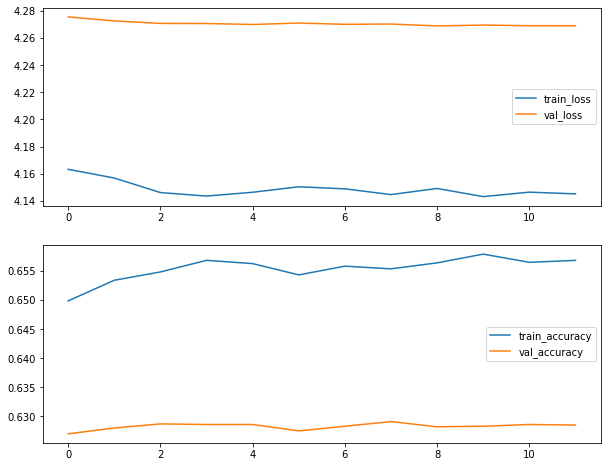

In [19]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history6.history["loss"], label="train_loss")
ax[0].plot(history6.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history6.history["accuracy"], label= "train_accuracy")
ax[1].plot(history6.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

In [20]:
pd.DataFrame(history6.history).to_csv('./history/network2_model6.csv')

# Top Validation Accuracy : 62.91%

# Results
### The training and validation loss through the whole training

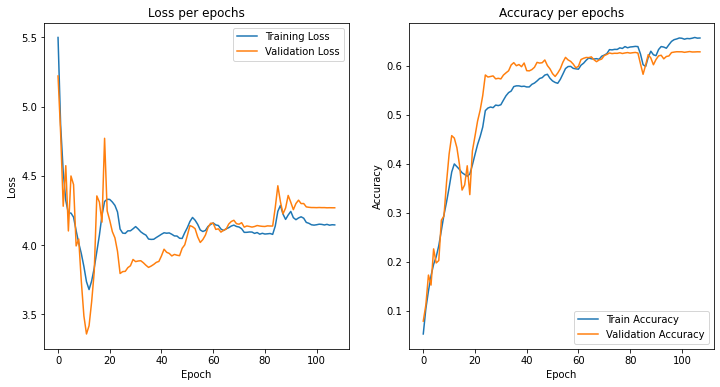

In [28]:
#Load the previous training record
import pandas as pd
history1 = pd.read_csv('./history/network2_model1.csv')
history2 = pd.read_csv('./history/network2_model2.csv')
history3 = pd.read_csv('./history/network2_model3.csv')
history4 = pd.read_csv('./history/network2_model4.csv')
history5 = pd.read_csv('./history/network2_model5.csv')
history6 = pd.read_csv('./history/network2_model6.csv')

history = history1.append([history2,history3, history4, history5, history6], ignore_index=True)
history = history.drop(['Unnamed: 0'], axis=1)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history['loss'], label='Training Loss')
ax[0].plot(history['val_loss'], label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss per epochs')
ax[0].legend()

ax[1].plot(history['accuracy'], label='Train Accuracy')
ax[1].plot(history['val_accuracy'], label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy per epochs')
ax[1].legend()

### The total trend of loss for both training and validation are decreasing, there is a visible drop of validation loss in the start of second training circle.
### Also, there is a slight increase of loss in the fifth round as we increased the base_lr and max_lr.
### The training loss suffer lighter influence of changing lr than validation.

# Error Analysis

In [29]:
from tensorflow.keras.models import load_model
final_model = load_model('./Network2_model/model6.hdf5')

In [30]:
pred=final_model.predict(validation_generator, steps= np.ceil(num_validation/batch_size), verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

79/79 [==============================] - 19s 236ms/step


In [31]:
# Predicted classes from their indices
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions[:10]

['n03444034',
 'n02231487',
 'n02948072',
 'n02808440',
 'n02808440',
 'n04399382',
 'n04179913',
 'n02823428',
 'n04146614',
 'n02226429']

In [32]:
import os
class_to_name = dict()
file = open('tiny-imagenet-200/words.txt','r')
data= file.readlines()
for line in data:
  words = line.strip('\n').split('\t')
  class_to_name[words[0]] = words[1].split(',')[0]
file.close()

In [33]:
# Asserting Validation Class names from words.txt
validation_class_names={}
for _class in validation_generator.class_indices.keys():
  validation_class_names.update({_class : class_to_name[_class]})

In [34]:
# Classification Report of val classes
from sklearn.metrics import confusion_matrix, classification_report

pred_result = classification_report(validation_generator.classes, predicted_class_indices,
                            #target_names=validation_generator.class_indices.keys(),
                            target_names=validation_class_names.values(),
                            digits=4)
print(pred_result)

                          precision    recall  f1-score   support

                goldfish     0.8036    0.9000    0.8491        50
European fire salamander     0.8776    0.8600    0.8687        50
                bullfrog     0.6154    0.6400    0.6275        50
             tailed frog     0.5455    0.4800    0.5106        50
      American alligator     0.5918    0.5800    0.5859        50
         boa constrictor     0.6222    0.5600    0.5895        50
               trilobite     0.7736    0.8200    0.7961        50
                scorpion     0.8056    0.5800    0.6744        50
             black widow     0.7736    0.8200    0.7961        50
               tarantula     0.6400    0.6400    0.6400        50
               centipede     0.6596    0.6200    0.6392        50
                   goose     0.7308    0.7600    0.7451        50
                   koala     0.7407    0.8000    0.7692        50
               jellyfish     0.7679    0.8600    0.8113        50
         

### Sort the precision and find classes with top 5 errors made by the final model.

In [35]:
cf = confusion_matrix(validation_generator.classes, predicted_class_indices) 
precision = (cf / np.sum(cf, axis=0)).diagonal()
precision[:5]

array([0.80357143, 0.87755102, 0.61538462, 0.54545455, 0.59183673])

In [36]:
prec = pd.DataFrame.from_dict(validation_class_names, orient='index', columns=['class'])
prec['precision'] = precision
prec.sort_values(['precision'])

,class,precision
n03970156,plunger,0.187500
n03976657,pole,0.275000
n04507155,umbrella,0.318182
n04023962,punching bag,0.333333
n03983396,pop bottle,0.340426
...,...,...
n01629819,European fire salamander,0.877551
n04486054,triumphal arch,0.880000
n03662601,lifeboat,0.911111
n02281406,sulphur butterfly,0.914894


### Get top-5 errors class: plunger, pole, umbrella, punching bag and pop bottle.
So, we take a look at the plunger class.

In [37]:
plunger = val_data[val_data['Class'] == 'n03970156']
plunger_datagen = ImageDataGenerator(rescale=1/255.)
plunger_generator = plunger_datagen.flow_from_dataframe(plunger,directory='./tiny-imagenet-200/val/images/', 
                                                         x_col='File', y_col='Class', 
                                                         target_size=(img_width, img_height),
                                                         class_mode='categorical', 
                                                         batch_size=batch_size, 
                                                         shuffle=False, seed=101)
plunger.head()

Found 50 validated image filenames belonging to 1 classes.


,File,Class
71,val_71.JPEG,n03970156
119,val_119.JPEG,n03970156
137,val_137.JPEG,n03970156
169,val_169.JPEG,n03970156
195,val_195.JPEG,n03970156


In [38]:
plunger_pred = final_model.predict(plunger_generator)
plunger_class = np.argmax(plunger_pred, axis=1)
plunger_predictions = [validation_class_names[labels[k]] for k in plunger_class]
plunger_predictions[:10]

['gasmask',
 'turnstile',
 'space heater',
 'projectile',
 'plunger',
 'plunger',
 'punching bag',
 'space heater',
 'plunger',
 'plunger']

For the first 10 pictures, only 3 are correctly predicted.
### Visualize first 8 images.

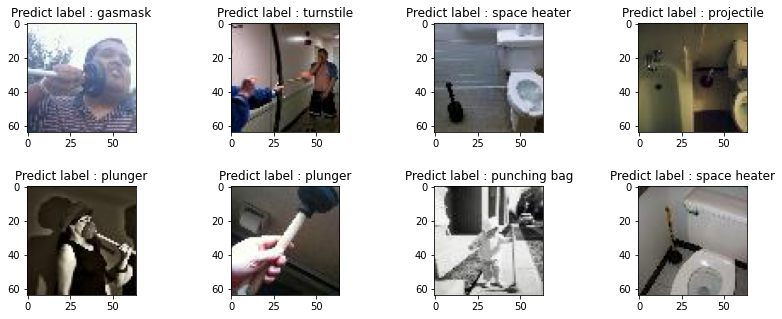

In [39]:
fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i+1)
    sub.imshow(plunger_generator[0][0][i,:,:])
    sub.set_title('Predict label : %s' %plunger_predictions[i])

fig.subplots_adjust(hspace=0.5)

#### We can see there are some misunderstanding in the intent of image.